In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers, mixed_precision, regularizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-10-29 18:36:17.313906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 18:36:17.344799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 18:36:17.354355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 18:36:17.377695: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = [f"R_{i}" for i in range(100)]

dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))
for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]
X, Y = X.T, Y.T

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

x = scaler_X.fit_transform(X)

# Mask and scale only non-zero values in Y
nz = Y != 0
y = np.copy(Y)  # Copy Y to keep the structure with zeros intact
y[nz] = scaler_Y.fit_transform(Y[nz].reshape(-1, 1)).flatten()

x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

tuner_dir = 'trials'

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

In [12]:
# Load model from file
#model = tf.keras.models.load_model("../../models/model_nl.keras")

model = tf.keras.models.Sequential([
    layers.Dense(320, activation='relu', input_shape=(x_ncols,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(224, activation='relu'),
    layers.Dense(y_ncols, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 320)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 224)            │       114,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        22,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,964 (1.16 MB)

 Trainable params: 304,964 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
batch_size = 128
num_epochs = 1000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-5, 
    patience=10
)

# Setup checkpointing
ckpt_path = "../../checkpoints/mvsr_nl.keras"
ckpt_dir = os.path.dirname(ckpt_path)

# Set up another callback that saves the model's weights
save_weights = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, verbose=0)

In [14]:
training = model.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early], verbose=2)

Epoch 1/1000


2024-10-29 18:39:07.952585: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_165', 60 bytes spill stores, 60 bytes spill loads

2024-10-29 18:39:07.954949: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_165', 320 bytes spill stores, 320 bytes spill loads

2024-10-29 18:39:08.427769: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_179', 340 bytes spill stores, 292 bytes spill loads

2024-10-29 18:39:09.632241: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_380', 20 bytes spill stores, 20 bytes spill loads

2024-10-29 18:39:09.666521: I external/local_xla/xla/stream_

67/67 - 14s - 206ms/step - loss: 0.0053 - mae: 0.0428 - val_loss: 0.0012 - val_mae: 0.0207
Epoch 2/1000
67/67 - 0s - 2ms/step - loss: 8.8551e-04 - mae: 0.0173 - val_loss: 7.2559e-04 - val_mae: 0.0144
Epoch 3/1000
67/67 - 0s - 2ms/step - loss: 6.3220e-04 - mae: 0.0130 - val_loss: 5.7278e-04 - val_mae: 0.0123
Epoch 4/1000
67/67 - 0s - 2ms/step - loss: 4.9358e-04 - mae: 0.0113 - val_loss: 4.5204e-04 - val_mae: 0.0107
Epoch 5/1000
67/67 - 0s - 2ms/step - loss: 3.9450e-04 - mae: 0.0100 - val_loss: 3.7646e-04 - val_mae: 0.0098
Epoch 6/1000
67/67 - 0s - 2ms/step - loss: 3.4157e-04 - mae: 0.0091 - val_loss: 3.4254e-04 - val_mae: 0.0088
Epoch 7/1000
67/67 - 0s - 2ms/step - loss: 3.0714e-04 - mae: 0.0084 - val_loss: 3.0064e-04 - val_mae: 0.0082
Epoch 8/1000
67/67 - 0s - 2ms/step - loss: 2.7551e-04 - mae: 0.0078 - val_loss: 2.7362e-04 - val_mae: 0.0080
Epoch 9/1000
67/67 - 0s - 2ms/step - loss: 2.5072e-04 - mae: 0.0074 - val_loss: 2.4728e-04 - val_mae: 0.0072
Epoch 10/1000
67/67 - 0s - 2ms/step -

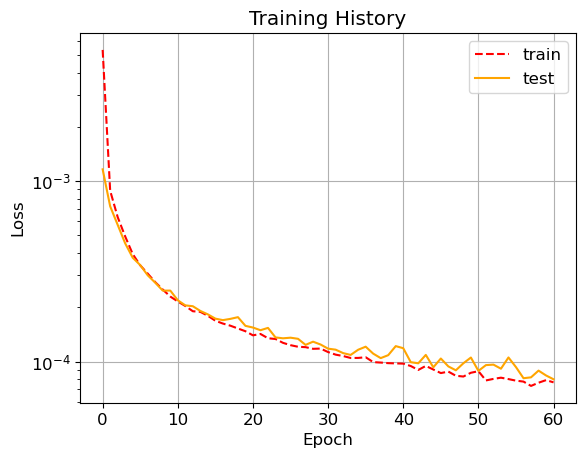

In [15]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

In [16]:
y_pr = model.predict(x_vl)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [17]:
def post_process_radius(y_pred_radius):
    for i in range(len(y_pred_radius)):
        # Get the current predicted radius vector for the i-th sample
        radius_vector = y_pred_radius[i]

        # Step 1: Find the last meaningful non-zero value (smallest non-zero)
        non_zero_indices = np.nonzero(radius_vector)[0]
        if len(non_zero_indices) == 0:
            continue  # Skip if all values are zero

        # Find the last meaningful non-zero value (smallest non-zero value)
        last_nonzero_idx = non_zero_indices[-1]  # Index of the last non-zero value

        # Step 2: Set all values after the last non-zero to zero
        radius_vector[last_nonzero_idx + 1:] = 0

        # Step 3: Linearly interpolate any intermediate zeros between two non-zero values
        zero_indices = np.where((radius_vector == 0) & (np.arange(len(radius_vector)) < last_nonzero_idx))[0]
        
        for zero_idx in zero_indices:
            # Find the nearest non-zero values on the left and right of the zero
            left_nonzero_idx = zero_idx - 1
            while left_nonzero_idx >= 0 and radius_vector[left_nonzero_idx] == 0:
                left_nonzero_idx -= 1
            
            right_nonzero_idx = zero_idx + 1
            while right_nonzero_idx < len(radius_vector) and radius_vector[right_nonzero_idx] == 0:
                right_nonzero_idx += 1
            
            # Perform linear interpolation if we have valid left and right non-zero values
            if left_nonzero_idx >= 0 and right_nonzero_idx < len(radius_vector):
                left_value = radius_vector[left_nonzero_idx]
                right_value = radius_vector[right_nonzero_idx]
                
                # Linear interpolation for the zero at zero_idx
                radius_vector[zero_idx] = left_value + (right_value - left_value) * (zero_idx - left_nonzero_idx) / (right_nonzero_idx - left_nonzero_idx)

        # Update the radius vector in the prediction array
        y_pred_radius[i] = radius_vector

    return y_pred_radius

print(y_pr[3])
y_pr2 = post_process_radius(y_pr)
print(y_pr2[3])

[ 8.2858765e-01  6.6759789e-01  5.5999881e-01  4.9604070e-01
  4.3930858e-01  3.9875999e-01  3.7429366e-01  3.4607387e-01
  3.3209878e-01  3.0819625e-01  2.9151493e-01  2.8589714e-01
  2.7513701e-01  2.7470508e-01  2.5876501e-01  2.5107199e-01
  2.4663700e-01  2.5031018e-01  2.4307577e-01  2.4364153e-01
  2.2887301e-01  2.3420097e-01  2.3672260e-01  2.3856966e-01
  2.3764890e-01  2.3865283e-01  2.3961778e-01  2.4402438e-01
  2.4328871e-01  2.3535725e-01  2.3858543e-01  2.4208620e-01
  2.4195825e-01  2.4880600e-01  2.4486071e-01  2.4887900e-01
  2.4864121e-01  2.5907475e-01  2.5537366e-01  2.5859568e-01
  2.5224465e-01  2.6047263e-01  2.7039230e-01  2.6873159e-01
  2.6376387e-01  2.7068728e-01  2.7550122e-01  2.7751154e-01
  2.7372324e-01  2.7888066e-01  2.7594817e-01  2.7866521e-01
  2.8663820e-01  2.8969049e-01  2.8675717e-01  2.7764785e-01
  2.8067186e-01  2.7915335e-01  2.8203511e-01  2.9016435e-01
  2.7679208e-01  2.8026131e-01  2.8303126e-01  2.7918935e-01
  2.8086221e-01  2.88401